In [1]:
import jax
import jax.numpy as jnp
from jax import vmap
import matplotlib.pyplot as plt

In [2]:
# use float64
from jax.config import config
config.update("jax_enable_x64", True)

# use retina plots
%config InlineBackend.figure_format='retina'

In [3]:
def predict_fn(w):
    return x_train @ w

In [4]:
# generate x
n = 100
d = 2
noise_sd = 1
ds_key = jax.random.PRNGKey(0)
x_key, y_key = jax.random.split(ds_key, 2)
w_true = jnp.array([2, -2])
x_train = 10 * jax.random.uniform(x_key, [n, d])
y_train = predict_fn(w_true) + noise_sd * jax.random.normal(y_key, [n])

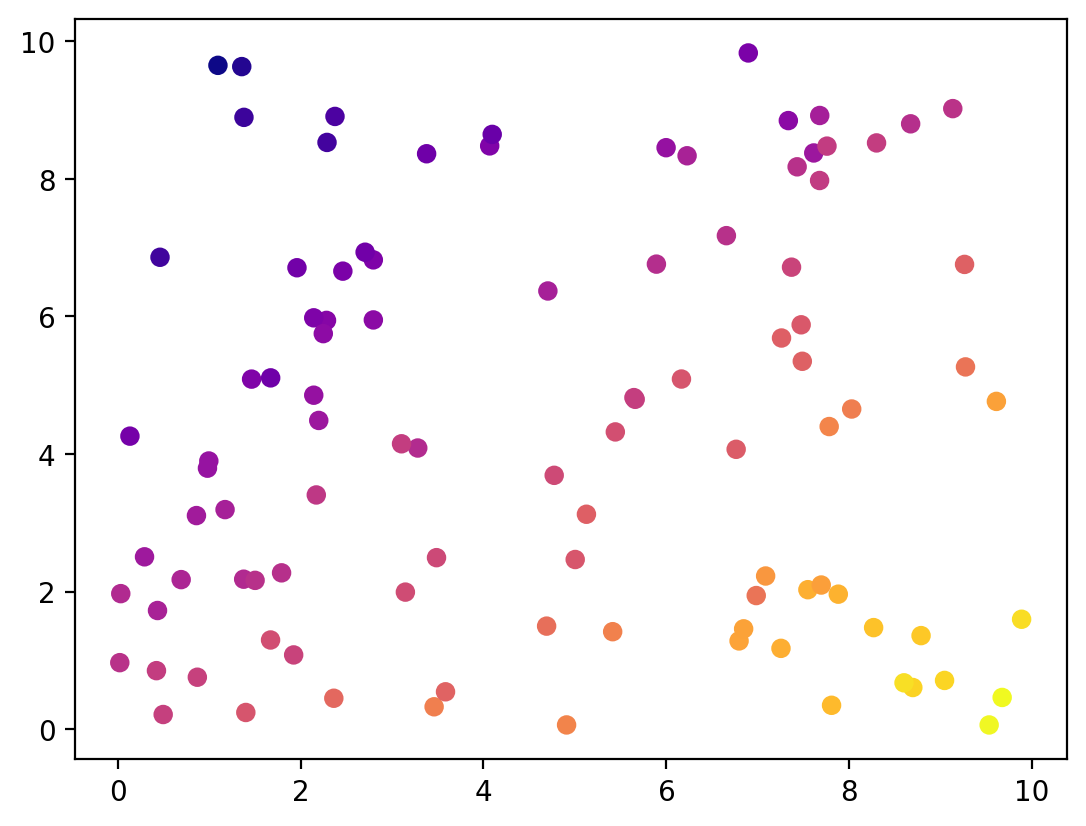

In [5]:
# plot train data
plt.scatter(*x_train.T, c=y_train, cmap='plasma')
plt.show()

In [6]:
def gaussian_log_pdf(y, mean, std):
    return -0.5 * jnp.log(std**2 * 2 * jnp.pi) - 0.5 * ((y-mean)/std)**2

def laplace_log_pdf(y, mu=0, b=0.005):
    return -jnp.log(2*b) - jnp.abs(y - mu)/b

# define prior function
def log_prior_fn(w):
    # return gaussian_log_pdf(w, 0, 0.13).sum()
    return laplace_log_pdf(w).sum()

# define likelihood function
def log_like_fn(w):
    y_hat = predict_fn(w)
    return gaussian_log_pdf(y_hat, y_train, 10).sum()

In [7]:
# create grid of weights
w_min = -5
w_max = 5
grid_size = 100
w1 = jnp.linspace(w_min, w_max, grid_size)
w2 = jnp.linspace(w_min, w_max, grid_size)
w = jnp.stack(jnp.meshgrid(w1, w2), -1) # [grid_size, grid_size, 2]
w = w.reshape([grid_size*grid_size, 2])

# compute prior
prior = vmap(log_prior_fn)(w)

# compute likelihood
likelihood = vmap(log_like_fn)(w)

# compute posterior
posterior = prior + likelihood

print(f'prior range: {prior.min():.0f} ... {prior.max():.0f}')
print(f'likelihood range: {likelihood.min():.0f} ... {likelihood.max():.0f}')

prior range: -1991 ... -11
likelihood range: -1644 ... -323


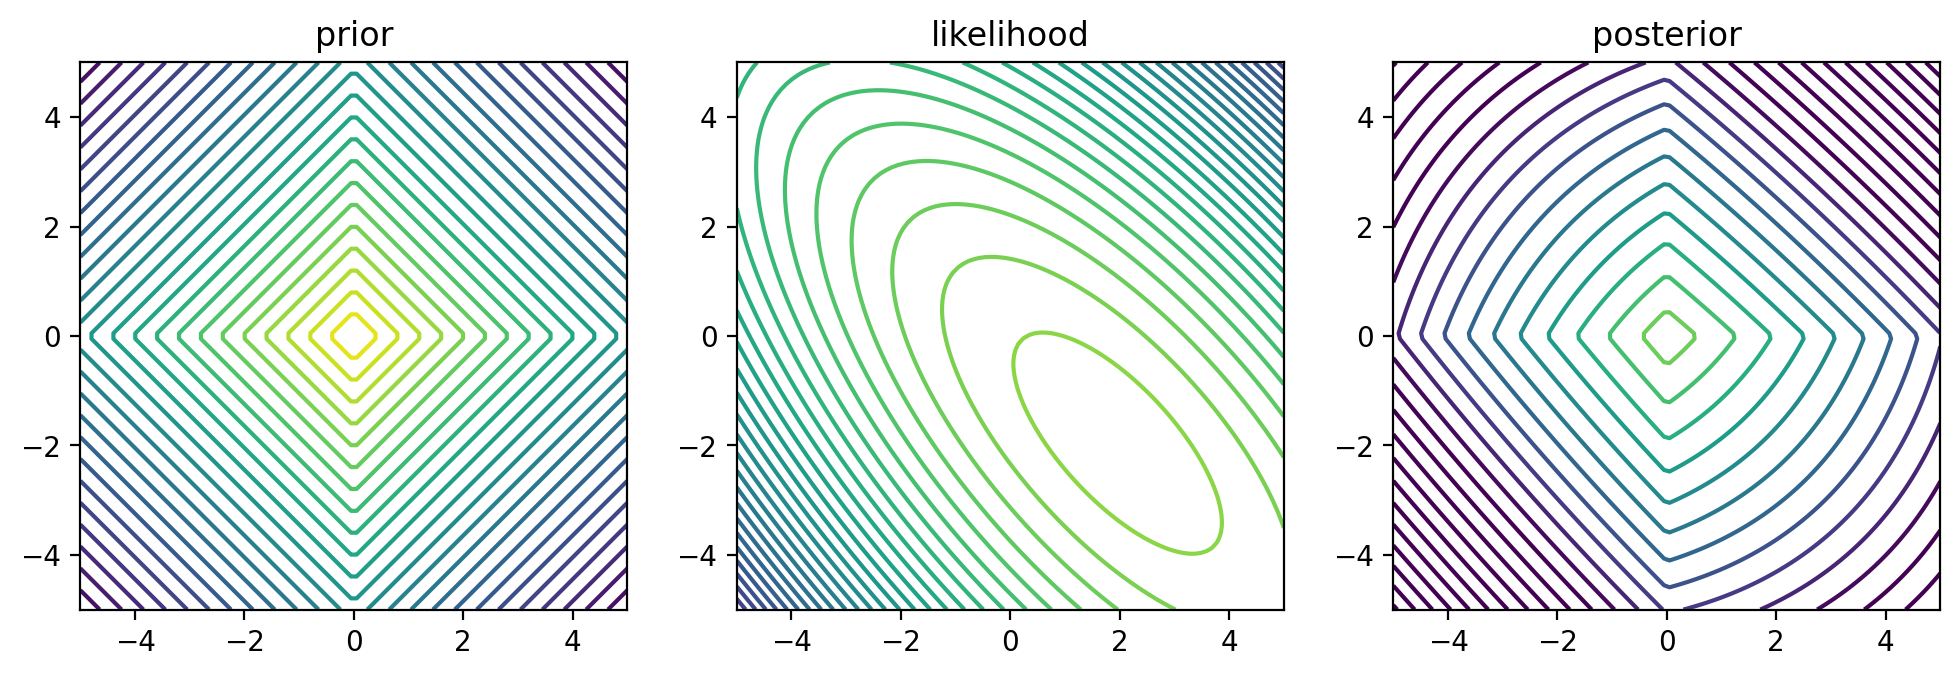

In [8]:
# plot prior, likelihood, posterior
fig, axs = plt.subplots(1, 3, figsize=[12, 8])
extent = [w_min, w_max, w_min, w_max]
cmap = 'viridis'
levels = 30
vmin = -2_000
vmax = 0

# prior
axs[0].contour(prior.reshape([grid_size, grid_size]), cmap=cmap, extent=extent, levels=levels, vmin=vmin, vmax=vmax)
axs[0].set_title("prior")
axs[0].set_aspect(1)

# likelihood
axs[1].contour(likelihood.reshape([grid_size, grid_size]), cmap=cmap, extent=extent, levels=levels, vmin=vmin, vmax=vmax)
axs[1].set_title("likelihood")
axs[1].set_aspect(1)

# posterior
axs[2].contour(posterior.reshape([grid_size, grid_size]), cmap=cmap, extent=extent, levels=levels, vmin=vmin, vmax=vmax)
axs[2].set_title("posterior")
axs[2].set_aspect(1)

plt.show()